In [1]:
import ugradio
from astropy.coordinates import SkyCoord
from astropy.time import Time
import time
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import mpl_toolkits.axes_grid1 as axgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy

mpl.rcParams['axes.linewidth'] = 3 #set the value globally
plt.rcParams['mathtext.fontset'],plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 22})

No module named 'rtlsdr'


In [2]:
volts_raw, times_raw = np.load('data/sun_6hr.npy')

In [3]:
beginning_time = min(times_raw)
ending_time = max(times_raw)

beginning_local_time = ugradio.timing.local_time(beginning_time)
ending_local_time = ugradio.timing.local_time(ending_time)

beginning_jd = ugradio.timing.julian_date(beginning_time)
ending_jd = ugradio.timing.julian_date(ending_time)


print('Beginning time in local time (PST):', beginning_local_time, '\nEnding time in local time (PST):', ending_local_time)

print('\nBeginning JD:', beginning_jd, '\nEnding JD:', ending_jd)

# beginning_local_time[11:19]

Beginning time in local time (PST): Tue Mar 22 08:27:25 2022 
Ending time in local time (PST): Tue Mar 22 14:26:52 2022

Beginning JD: 2459661.14404817 
Ending JD: 2459661.3936627596


In [4]:
import astropy.constants as con
import astropy.units as u

data = np.array([times_raw,volts_raw])

val = con.c / (10.5e9 * u.Hz)
λ = val.to(u.m).value

L, long, alt_nch = ugradio.nch.lat, ugradio.nch.lon, ugradio.nch.alt 
# λ = 2.77 / 100 # 2.77 cm

jds=ugradio.timing.julian_date(data[0])
α,δ =ugradio.coord.sunpos(jds[0])
δ=(np.pi/180)*δ

LSTs = ugradio.timing.lst(jds,lon=long) #feed in an array of julian dates observed.

h_s = LSTs-α*(np.pi/180) 
h_s = np.linspace(h_s[0],(h_s[0]+(15*6*(np.pi/180))),len(jds)) #h_s for 6hr sun data

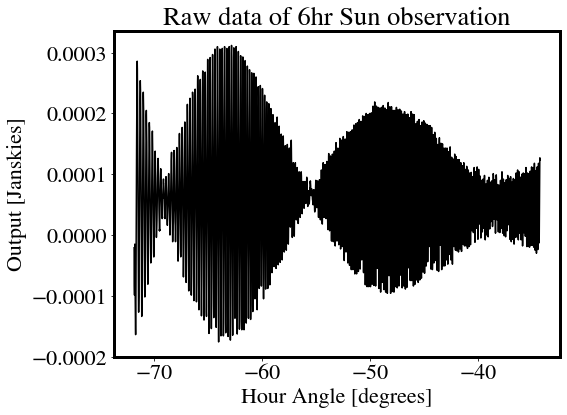

In [5]:
times = times_raw[:10000]
volts = volts_raw[:10000]

plt.figure(figsize=(8,6))
plt.title('Raw data of 6hr Sun observation')
plt.plot((h_s[:10000] * (180/np.pi)) - 360, volts, 'k')
plt.xlabel('Hour Angle [degrees]')
plt.ylabel('Output [Janskies]')
plt.show()

# Fringe Frequency Investigation

In this section we take the raw data of the sun over 6hrs and split the data up into N evenly spaced chunks. With this we then compute the power spectrum of each chunk and show how they peak at different frequencies. This data was taken in the morning so the fringe frequency increases with hour angle.

In [6]:
def pow_fft(arr):
    return np.fft.fftshift(np.abs(np.fft.fft(arr))**2)

def freq(arr, dt):
    return np.fft.fftshift(np.fft.fftfreq(len(arr), dt))


def split_data(data, time, num_splits):
    n = len(data)
    split_size = n // num_splits
    data_splits = []
    freq_splits = []
    for i in range(num_splits):
        data_frac = data[i*split_size:(i+1)*split_size]
        time_frac = time[i*split_size:(i+1)*split_size]
        dt = np.mean(np.diff(time_frac))
        frequency = freq(time_frac, dt)
        pow_frac = pow_fft(data_frac)
        
        data_splits.append(pow_frac)
        freq_splits.append(frequency)
        
    return data_splits, freq_splits

In [7]:
split_power, split_freqs = split_data(volts, times, 12)

middle = split_power[0].shape[0] // 2

for i in range(12):
    split_power[i][middle - 2: middle + 2] = 0 #remove all the peaks at 0 Hz

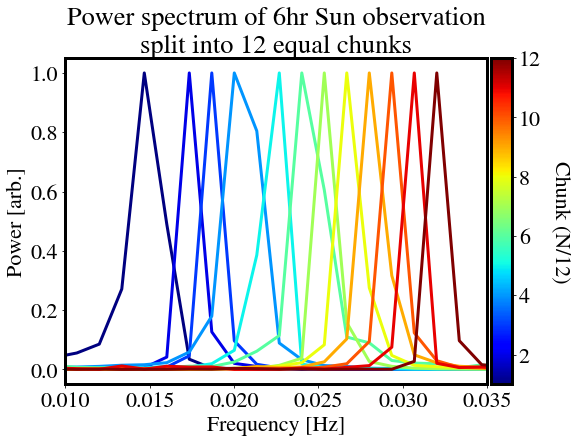

In [8]:
cmap = plt.cm.jet
n = len(split_power)
colors = cmap(np.linspace(0,1,n))

fig, ax = plt.subplots(1,1, figsize=(8,6))
plt.title('Power spectrum of 6hr Sun observation\nsplit into {0:.0f} equal chunks'.format(len(split_power)))

for i in range(len(split_power)):
    ax.plot(split_freqs[i], split_power[i] / np.max(split_power[i]), color=colors[i], linewidth=3)
    
norm_scaling = mpl.colors.Normalize(vmin=min(range(len(split_power)))+1, vmax=max(range(len(split_power)))+1)
divider = axgrid.make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.05)
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm_scaling, cmap=cmap), cax=cax)
cbar.set_label(label= 'Chunk (N/{0:.0f})'.format(len(split_power)), rotation=270, labelpad=30)

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Power [arb.]')
# ax.vlines(x=0.03, ymin=0, ymax=1, color="blue")
# ax.vlines(x=0.0315, ymin=0, ymax=1, color="blue")
ax.set_xlim(0.01, 0.035)
plt.show()

In [9]:
n_freqs, p_freqs, indeces = [], [], []
for i in range(12):
    normed_power = split_power[i] / np.max(split_power[i]) #normalize to 1 to make it easy to find peaks
    
    #find the peaks
    index = np.where(np.isclose(normed_power,1.0, rtol=1e-1))[0]
    freqs = split_freqs[i][index]
    n_freqs.append(freqs[0])
    p_freqs.append(freqs[1])
    indeces.append(index)

In [10]:
n = len(split_power)
split=int(23964/n)
ha_peaks, ff = [],[]
for i in range(n):
    ha_peaks.append((h_s[i*split]*180/np.pi)-360)
    
val = con.c / (10.5e9 * u.Hz)
λ = val.to(u.m).value
L, long, alt_nch = ugradio.nch.lat, ugradio.nch.lon, ugradio.nch.alt 
alpha,δ=ugradio.coord.sunpos(jds[0])
δ=(np.pi/180)*δ
LSTs = ugradio.timing.lst(jds,lon=long)
hs = LSTs - alpha*(np.pi/180)
Bew=14.7024
Bns=1.8235
for i in range(n):
    val = (((Bew/λ)*np.cos(δ)*np.cos(ha_peaks[i]*np.pi/180)) - 
           (Bns/λ)*np.sin(L)*np.cos(δ)*np.sin(ha_peaks[i]*np.pi/180))*(2*np.pi/86141)
    ff.append(val)
ff = np.array(ff)

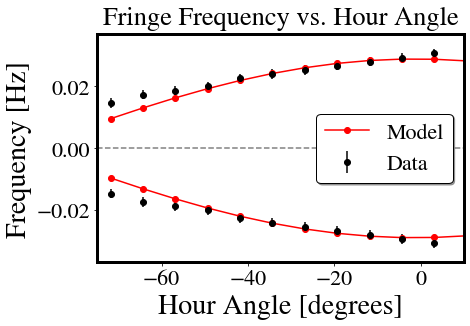

In [12]:
plt.figure(figsize=(7,5))
plt.plot(ha_peaks, ff / 1.3, 'r', marker='o', label="Model")
plt.plot(ha_peaks, ff*-1 / 1.3 , 'r', marker='o')
plt.errorbar(ha_peaks, p_freqs,yerr=0.0015, color="black", fmt="o", label="Data")
plt.errorbar(ha_peaks, n_freqs,yerr=0.0015, color="black", fmt="o")
plt.xlabel('Hour Angle [degrees]', fontsize=28)
plt.ylabel('Frequency [Hz]', fontsize=28)
plt.title('Fringe Frequency vs. Hour Angle', pad=10)
plt.hlines(y=0, xmin=-75, xmax=20, color="grey", linestyle="--")
plt.xlim(-75,10)
plt.legend(edgecolor="black", shadow=True)
plt.tight_layout()
# plt.savefig("Fringe_Frequency.pdf", dpi=300, bbox_inches="tight")
plt.show()

# Diameter Measurement

In this section we constrain the diameter of the Sun using the Bessel function envelope. We expect the 2D FT of the Sun to be a bessel function of the first kind. 

$$V_{\nu}(u,v) = \underbrace{\exp({-2 \pi i w})}_\text{Point Source Fringe} \times \underbrace{\int \int A_{\nu} (\ell, m) I_{\nu} (\ell, m) \exp \left(-2 \pi i (u\ell + vm) \right)\; d\ell  dm }_\text{Fringe Modulation = 2D FT of $I_\nu(\ell, m)$ for an object} \; .$$

### Let's plot the expected function

In [13]:
#import the bessel function
import scipy.special
import scipy.signal

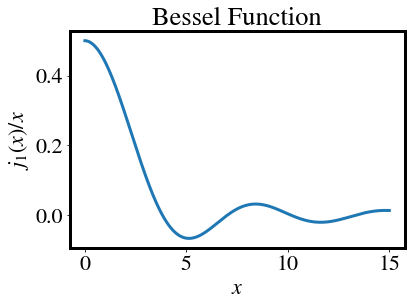

In [14]:
x = np.linspace(0.01,15,10000)
j1 = scipy.special.j1(x)

plt.figure(figsize=(6,4))
plt.title("Bessel Function")
plt.plot(x, j1/x, linewidth=3)
plt.ylabel("$j_1(x)/x$")
plt.xlabel("$x$")
plt.show()

Let's center the data

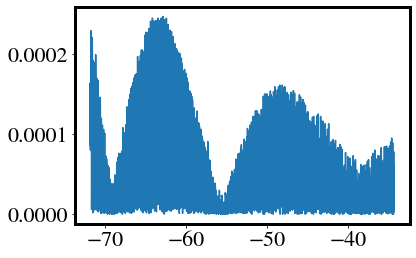

In [15]:
centered_abs_sun_data = np.abs(data[1,:17000] - np.mean(data[1,:17000]))
plt.plot(h_s[:10000] * (180/np.pi) - 360, centered_abs_sun_data[:10000])
plt.show()

and fourier transform the data to look at the frequency components

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1390: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


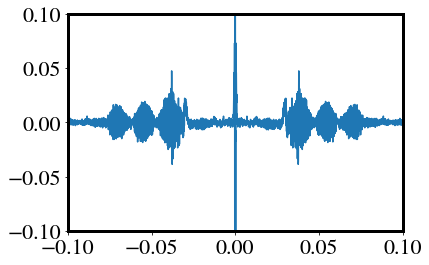

In [16]:
fft = np.fft.fftshift(np.fft.fft(centered_abs_sun_data))
freqs = freq(data[0,:17000], np.mean(np.diff(data[0,:17000])))
plt.plot(freqs, fft)
plt.ylim(-.1,.1)
plt.xlim(-0.1, 0.1)
plt.show()

From here we can fourier filter the data by applying a low pass filter to the data.

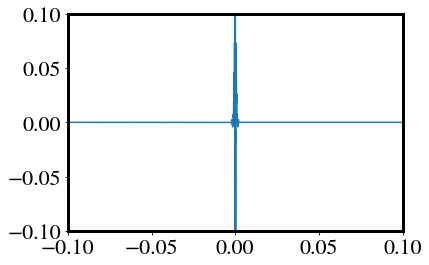

In [17]:
fft[np.where(freqs > 0.002)] = 0
fft[np.where(freqs < -0.002)] = 0
plt.plot(freqs, fft)
plt.ylim(-.1,.1)
plt.xlim(-0.1, 0.1)
plt.show()

Now let's Invert the Fourier Transform of the filtered data to get the envelope

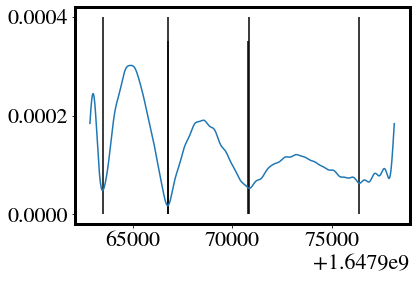

In [18]:
filtered_sun_data = np.fft.ifft(fft)

centered_abs_filtered = np.abs(filtered_sun_data - np.mean(filtered_sun_data))
index = scipy.signal.argrelmin(centered_abs_filtered, order=2000)

minima = data[0,index][0]

plt.plot(data[0,:17000], 2*centered_abs_filtered)
# plt.plot(sun_times[:10000], (sun_data - np.median(sun_data))[:10000])
# np.where(sun_times < )
# plt.xlim(65000+1.6479e9, 72500+1.6479e9)
plt.vlines(66750+1.6479e9, 0,0.00035)
plt.vlines(70800+1.6479e9, 0, 0.00035)
plt.vlines(minima, ymin=0, ymax=0.0004)

Let's fit a polynomial to the envelope minima

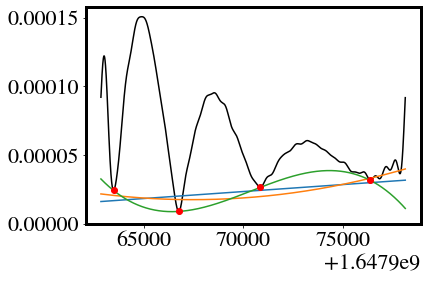

In [19]:
minima = data[0,index] - data[0,0]
minima_data = centered_abs_filtered[index]

plt.plot(data[0, :17000], centered_abs_filtered, c='k')
plt.scatter(minima + data[0,0], minima_data, c='r', zorder=5)

p1 = np.polyfit(minima[0], minima_data, deg=1)
y1 = np.polyval(p1, data[0,:17000] - data[0,0])
plt.plot(data[0,:17000], y1)

p2 = np.polyfit(minima[0], minima_data, deg=2)
y2 = np.polyval(p2, data[0,:17000] - data[0,0])
plt.plot(data[0,:17000], y2)

p3 = np.polyfit(minima[0], minima_data, deg=3)
y3 = np.polyval(p3, data[0,:17000] - data[0,0])
plt.plot(data[0,:17000], y3)
plt.show()

Now we can see the 3rd degree polynomial better removes the added signal from the sunspots

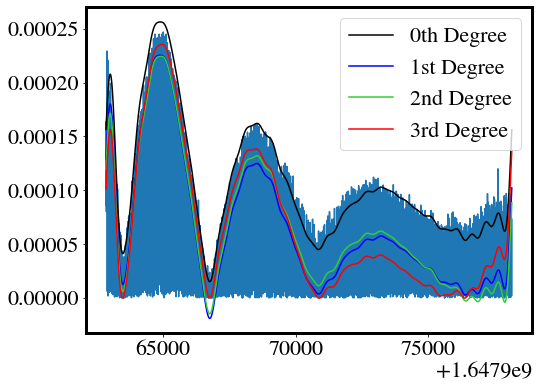

In [20]:
plt.figure(figsize=(8,6))
plt.plot(data[0,:17000], centered_abs_sun_data)
plt.plot(data[0, :17000], 1.7*centered_abs_filtered, c='k', label="0th Degree")
plt.plot(data[0, :17000], 1.7*(centered_abs_filtered - y1), c='blue', label="1st Degree")
plt.plot(data[0, :17000], 1.7*(centered_abs_filtered - y2), c='limegreen', label="2nd Degree")
plt.plot(data[0, :17000], 1.7*(centered_abs_filtered - y3), c='red', label="3rd Degree")
plt.legend()
plt.show()

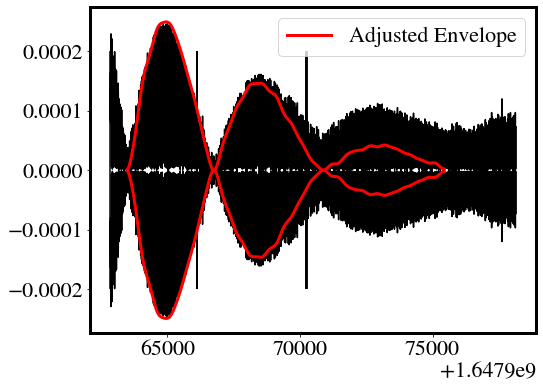

In [21]:
start,end = 700, 14000
plt.figure(figsize=(8,6))
plt.plot(data[0,:17000], centered_abs_sun_data, color="black")
plt.plot(data[0,:17000], centered_abs_sun_data*-1, color="black")
plt.plot(data[0, start:end], 1.8*(centered_abs_filtered - y3)[start:end], c='red', label="Adjusted Envelope", linewidth=3)
plt.plot(data[0, start:end], -1.8*(centered_abs_filtered - y3)[start:end], c='red', linewidth=3)
plt.vlines(data[0, np.where(np.isclose(1.7*(centered_abs_filtered - y3)[start:end],0, rtol=1e-10))], ymin=-0.0002,
          ymax=0.0002)
plt.legend()
plt.show()

Now we need to flip the envelope to be a bessel in some regions

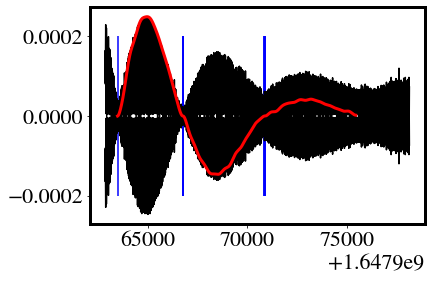

In [22]:
ydata = 1.8*(centered_abs_filtered - y3)[start:end]
inflections = np.where(np.isclose(ydata,0, rtol=1e-10))
point_1 = inflections[0][0]
point_2 = inflections[0][5]
point_3 = inflections[0][-2]
ydata[point_2:point_3] = -ydata[point_2:point_3]


plt.plot(data[0,:17000], centered_abs_sun_data, color="black")
plt.plot(data[0,:17000], centered_abs_sun_data*-1, color="black")
plt.plot(data[0, start:end], ydata, c='red', label="Adjusted Envelope", linewidth=3)
plt.vlines(data[0,start:end][inflections], ymin=-0.0002,
          ymax=0.0002, color="blue")
plt.show()

In [23]:
def bessel(ha, thetaR, A):
    d = 14.7099 #m 14.7106 or 14.8806
    delta = δ
    u = d * np.cos(delta) * np.cos(ha) / λ
    x = 2 * np.pi * thetaR * u
    return A * scipy.special.j1(x) / x 

In [24]:
p0 = [0.0046, 0.1]
pars, cov = scipy.optimize.curve_fit(bessel, h_s[start:end],ydata,p0,sigma=np.ones(len(ydata))*0.00004)

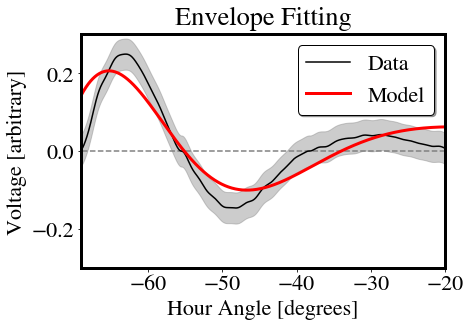

In [31]:
plt.figure(figsize=(7,5))
plt.plot(h_s[start:end]* 180 / np.pi - 360, 
         ydata/1e-3, 
         label="Data", color="black")
plt.plot(h_s[start:end]* 180 / np.pi - 360, 
         bessel(h_s[start:end], pars[0], pars[1])/1e-3, 
         label="Model", color="red", linewidth=3)
plt.fill_between(h_s[start:end]* 180 / np.pi - 360, 
                 y1 = (ydata - 0.00004)/1e-3, 
                 y2 = (ydata + 0.00004)/1e-3, 
                 alpha=0.4, color="grey")
plt.hlines(y=0, xmin=-70, xmax=-20, color="grey", linestyle="--")
plt.xlim(-69,-20)
plt.ylim(-.3,.3)
plt.title("Envelope Fitting", pad=10)
plt.ylabel("Voltage [arbitrary]")
plt.xlabel("Hour Angle [degrees]")
plt.legend(edgecolor="black", shadow=True)
plt.tight_layout()
plt.savefig("figures/Envelope_Fitting.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [26]:
sun_diameter = pars[0] * 180 / np.pi * 2
print('Sun diameter:', sun_diameter) 
print('Percent of expected value:', sun_diameter/(0.51) * 100)

Sun diameter: 0.4343467616559013
Percent of expected value: 85.16603169723554


In [27]:
sun_diameter * 215.032 * (np.pi/180)

1.6301105185429259

Let's do a more non linear fit to this

In [28]:
xdata=h_s[start:end]
ydata=ydata

N = 1000
chisq = []
thetas = np.linspace(0.00375,0.00384, N)

for i in range(N):
    chisq.append(np.sum(np.abs(ydata - bessel(xdata,thetas[i],pars[1]))**2) / 0.00004**2)
    
chisq = np.array(chisq)

chisq_θ_r = chisq / (len(ydata) - 2)

chisq_θ = chisq - np.min(chisq)
print(np.min(chisq_θ_r))

1.1748651830461994


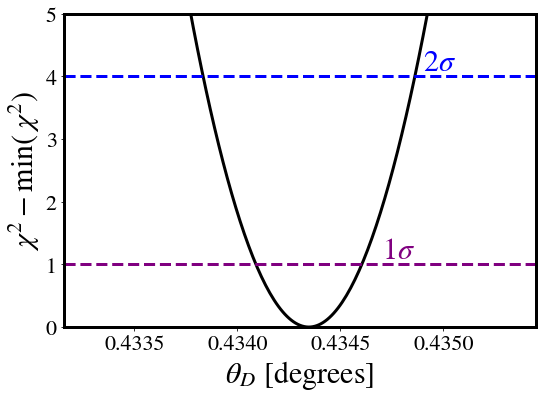

In [29]:
f, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(thetas* 180 / np.pi * 2, chisq_θ, linewidth=3, color="black")
ax.set_xlabel("$\\theta_D$ [degrees]", fontsize=30)
ax.set_ylabel("$\\chi^2 - \mathrm{min}(\; \chi^2)$", fontsize=30)
ax.axhline(y=4, color="blue", linestyle="--", linewidth=3, label="$2 \sigma$")
ax.axhline(y=1, color="purple", linestyle="--", linewidth=3, label="$1 \sigma$")
ax.text(0.4347,1.1, "$1 \sigma$", color="purple", fontsize=30)
ax.text(0.4349,4.1, "$2 \sigma$", color="blue", fontsize=30)
ax.set_ylim(0,5)
ax.set_xlim(0.00378 * 180 / np.pi * 2, 0.00380* 180 / np.pi * 2)
plt.tight_layout()
# plt.savefig("theta_chi_sq.pdf", dpi=300)
plt.show()



In [166]:
def calc_error(nσ):
    vals = (thetas[np.where(np.isclose(chisq_θ,nσ**2,rtol=1e-1))] - pars[0]) * 180 / np.pi * 2
    return vals[-1]

err_2 = calc_error(2)

print("We report the diameter of the sun to be {0:0.4f} +/- {1:0.4f} degrees with 2σ uncertainty".format(
    pars[0] * 180 / np.pi * 2,err_2))

We report the diameter of the sun to be 0.4343 +/- 0.0005 degrees with 2σ uncertainty


In [167]:
xdata=h_s[start:end]
ydata=ydata

N = 1000
chisq = []
As = np.linspace(pars[1] - 0.0001,pars[1] + 0.0001, N)

for i in range(N):
    chisq.append(np.sum(np.abs(ydata - bessel(xdata,pars[0],As[i]))**2) / 0.000035**2)
    
chisq = np.array(chisq)

chisq_A_r = chisq / (len(ydata) - 2)

chisq_A = chisq - np.min(chisq)
print(np.min(chisq_A_r))

1.5345177808446453


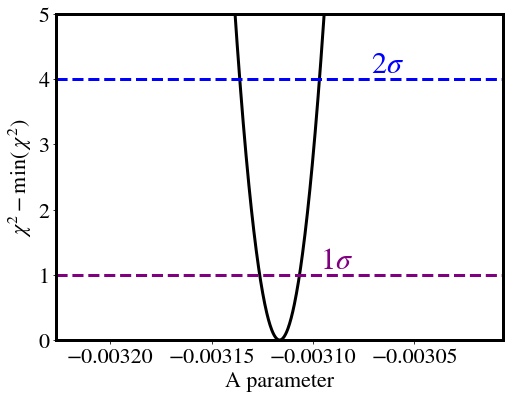

In [168]:
f, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(As, chisq_A, linewidth=3, color="black")
ax.set_xlabel("A parameter")
ax.set_ylabel("$\\chi^2 - \mathrm{min}(\; \chi^2)$")
ax.axhline(y=4, color="blue", linestyle="--", linewidth=3, label="$2 \sigma$")
ax.axhline(y=1, color="purple", linestyle="--", linewidth=3, label="$1 \sigma$")
ax.text(pars[1] + 0.00002,1.1, "$1 \sigma$", color="purple", fontsize=30)
ax.text(pars[1] + 0.000045,4.1, "$2 \sigma$", color="blue", fontsize=30)
ax.set_ylim(0,5)

plt.show()


